In [1]:
# Import necessary libraries and custom modules

# Allows the import of Jupyter notebooks as Python modules
import import_ipynb

# Import custom Tennis Analysis Tools module
import Tennis_Analysis_Tools as tennis_tools

# Import numerical computing library for handling arrays and mathematical functions
import numpy as np

# Import pandas library for data manipulation and analysis
import pandas as pd

# Import matplotlib library for creating visualizations and plots
import matplotlib.pyplot as plt

importing Jupyter notebook from Tennis_Analysis_Tools.ipynb


In [2]:
def preprocess_dataset(betting_data_dfs):
    
    """
    Preprocess the betting dataset to prepare it for analysis.

    This function filters the dataset to include only completed matches,
    replaces 'NR' (Not Ranked) with NaN in ranking columns, converts rankings
    to numeric values, fills NaN values with 100000 (representing unranked players),
    creates a column indicating if the higher-ranked player won, and keeps only
    the essential columns for analysis.

    """
    
    # Filter the dataset to include only completed matches
    betting_data_dfs = betting_data_dfs[betting_data_dfs['Comment'].isin(['Completed'])]

    # Reset the index to ensure it's sequential after filtering
    betting_data_dfs.reset_index(drop=True, inplace=True)
    
    # Replace 'NR' (Not Ranked) with NaN in 'WRank' and 'LRank' columns
    betting_data_dfs['WRank'].replace('NR', np.nan, inplace=True)
    betting_data_dfs['LRank'].replace('NR', np.nan, inplace=True)
    
    # Convert 'WRank' and 'LRank' columns to numeric, forcing errors to NaN
    betting_data_dfs['WRank'] = pd.to_numeric(betting_data_dfs['WRank'], errors='coerce')
    betting_data_dfs['LRank'] = pd.to_numeric(betting_data_dfs['LRank'], errors='coerce')

    # Fill NaN values in 'WRank' and 'LRank' with 100000 and convert to float
    betting_data_dfs['WRank'] = betting_data_dfs['WRank'].fillna(100000).astype(float)
    betting_data_dfs['LRank'] = betting_data_dfs['LRank'].fillna(100000).astype(float)

    # Create a column indicating if the higher-ranked player won (1 if true, 0 if false)
    betting_data_dfs['higher_rank_won'] = (betting_data_dfs['WRank'] < betting_data_dfs['LRank']).astype(int)

    # Define the essential columns to keep in the dataframe
    essential_columns = ['Date', 'Tournament', 'WRank', 'LRank', 'higher_rank_won', 'Winner', 'Loser']

    # Filter the dataframe to keep only the essential columns
    betting_data_filtered = betting_data_dfs[essential_columns]
    
    # Calculate the mean of numeric columns and fill NaN values with these means
    means = betting_data_filtered.select_dtypes(include=[np.number]).mean()
    betting_data_filtered.fillna(means, inplace=True)

    # Return the preprocessed dataframe
    return betting_data_filtered

In [3]:
def update_elo(winner_elo, loser_elo, tournament, K):
    
    """
    Update the Elo ratings for the winner and loser of a match.

    This function calculates the updated Elo ratings for the winner and loser
    based on the match outcome and the tournament type. The Elo rating system
    adjusts ratings based on the expected outcome of the match and the actual result.


    """
    # Calculate expected score for the winner
    expected_winner = 1 / (1 + 10 ** ((loser_elo - winner_elo) / 400))
    
    # Check if the tournament is one of the Grand Slams
    if tournament in ['Australian Open', 'French Open', 'Wimbledon', 'US Open']:
        # Calculate the change in Elo ratings for the winner in Grand Slams
        elo_change_winner = K * (1 - expected_winner)
        # Calculate the change in Elo ratings for the loser in Grand Slams
        elo_change_loser = K * (expected_winner - 1)
    else:
        # Default change in Elo ratings for non-Grand Slam tournaments
        elo_change_winner = K * (1 - expected_winner)
        elo_change_loser = K * (expected_winner - 1)

    # Update the Elo ratings by adding the change to the original ratings
    updated_winner_elo = winner_elo + elo_change_winner
    updated_loser_elo = loser_elo + elo_change_loser

    # Return the updated Elo ratings and the expected score for the winner
    return updated_winner_elo, updated_loser_elo, expected_winner


In [4]:
def calculate_elo_with_k(betting_data_dfs_preprocessed, k):
    
    """
    Calculate Elo ratings for players based on match results with a constant K value.

    This function processes the preprocessed betting dataset to calculate the Elo ratings
    for players based on match outcomes. It updates the Elo ratings for both winners and
    losers, and calculates the probability of the winner for each match. The function also
    records these updated Elo ratings and probabilities in the dataset.

    """
    # Create a set of unique player IDs from the 'Winner' and 'Loser' columns
    players_ids = pd.concat([betting_data_dfs_preprocessed['Winner'], betting_data_dfs_preprocessed['Loser']]).unique()
    
    # Initialize Elo scores for all players to 1500
    elo_scores_constant_k = {player: 1500 for player in players_ids}

    # Iterate over each match in the dataset
    for i in range(len(betting_data_dfs_preprocessed)):
        tennis_match_row = betting_data_dfs_preprocessed.iloc[i]
        winner_id = tennis_match_row['Winner']
        loser_id = tennis_match_row['Loser']
        tournament = tennis_match_row['Tournament']
        higher_ranked_wins = tennis_match_row['higher_rank_won']

        # Retrieve current Elo ratings for the winner and loser
        winner_elo_before = elo_scores_constant_k[winner_id]
        loser_elo_before = elo_scores_constant_k[loser_id]

        # Calculate updated Elo ratings and the probability of the winner
        winner_elo_after, loser_elo_after, prob_winner = update_elo(
            winner_elo_before, loser_elo_before, tournament, k)

        # Update Elo scores in the dictionary
        elo_scores_constant_k[winner_id] = winner_elo_after
        elo_scores_constant_k[loser_id] = loser_elo_after

        # Record the updated Elo ratings and probabilities in the DataFrame
        betting_data_dfs_preprocessed.at[i, 'winner_elo_before'] = winner_elo_before
        betting_data_dfs_preprocessed.at[i, 'winner_elo_after'] = winner_elo_after
        betting_data_dfs_preprocessed.at[i, 'loser_elo_before'] = loser_elo_before
        betting_data_dfs_preprocessed.at[i, 'loser_elo_after'] = loser_elo_after
        betting_data_dfs_preprocessed.at[i, 'prob_winner'] = prob_winner

        # Calculate and record the match outcome and probability for the higher-ranked player
        if higher_ranked_wins == 1:
            betting_data_dfs_preprocessed.at[i, 'match_outcome'] = int(prob_winner > 0.5)  # Convert boolean to int
            betting_data_dfs_preprocessed.at[i, 'prob_high_ranked'] = prob_winner
        else:
            betting_data_dfs_preprocessed.at[i, 'match_outcome'] = int((1 - prob_winner) > 0.5)  # Convert boolean to int
            betting_data_dfs_preprocessed.at[i, 'prob_high_ranked'] = 1 - prob_winner


In [5]:
# Initialize a dictionary to store dataframes for each year
betting_data_dfs = {}

In [6]:
# Loop through each year from 2005 to 2019
for current_year in range(2005, 2020): 
    # Determine the file extension based on the year
    file_extension = 'xls' if current_year < 2013 else 'xlsx'
    
    # Construct the file path using the determined file extension
    file_path = f"/Users/harishthota/Desktop/UOA Project/Betting_Odds_Tennis/{current_year}.{file_extension}"
    
    # Read the Excel file and store it in the dictionary with the year as the key
    betting_data_dfs[current_year] = pd.read_excel(file_path)

In [7]:
betting_data_dfs[2019]

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Lsets,Comment,B365W,B365L,PSW,PSL,MaxW,MaxL,AvgW,AvgL
0,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Dimitrov G.,...,0.0,Completed,1.36,3.00,1.36,3.37,1.42,3.60,1.35,3.18
1,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Raonic M.,...,0.0,Completed,1.18,4.50,1.23,4.68,1.27,4.84,1.22,4.26
2,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Kecmanovic M.,...,0.0,Completed,1.57,2.25,1.67,2.32,1.71,2.40,1.63,2.28
3,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Millman J.,...,1.0,Completed,1.40,2.75,1.41,3.13,1.45,3.20,1.40,2.95
4,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Uchiyama Y.,...,0.0,Completed,2.62,1.44,2.73,1.51,3.26,1.53,2.69,1.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2605,66,London,Masters Cup,2019-11-15,Masters Cup,Indoor,Hard,Round Robin,3,Nadal R.,...,1.0,Completed,1.44,2.75,1.39,3.26,1.48,3.30,1.41,2.93
2606,66,London,Masters Cup,2019-11-15,Masters Cup,Indoor,Hard,Round Robin,3,Zverev A.,...,0.0,Completed,1.90,1.90,2.14,1.79,2.24,2.06,1.92,1.90
2607,66,London,Masters Cup,2019-11-16,Masters Cup,Indoor,Hard,Semifinals,3,Tsitsipas S.,...,0.0,Completed,3.50,1.30,3.75,1.33,3.75,1.40,3.39,1.33
2608,66,London,Masters Cup,2019-11-16,Masters Cup,Indoor,Hard,Semifinals,3,Thiem D.,...,0.0,Completed,1.80,2.00,1.84,2.10,1.87,2.20,1.78,2.06


In [8]:
# Combine DataFrames from all years into a single DataFrame, reindexing rows.
betting_data_dfs = pd.concat(betting_data_dfs.values(), ignore_index = True)

In [9]:
# Display a summary of the DataFrame to understand its structure and data types
betting_data_dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40390 entries, 0 to 40389
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         40390 non-null  int64         
 1   Location    40390 non-null  object        
 2   Tournament  40390 non-null  object        
 3   Date        40390 non-null  datetime64[ns]
 4   Series      40390 non-null  object        
 5   Court       40390 non-null  object        
 6   Surface     40390 non-null  object        
 7   Round       40390 non-null  object        
 8   Best of     40390 non-null  int64         
 9   Winner      40390 non-null  object        
 10  Loser       40390 non-null  object        
 11  WRank       40375 non-null  float64       
 12  LRank       40303 non-null  float64       
 13  WPts        38701 non-null  float64       
 14  LPts        38631 non-null  float64       
 15  W1          40155 non-null  float64       
 16  L1          40157 non-

In [10]:
# Generate descriptive statistics for numerical columns in the DataFrame
betting_data_dfs.describe()

,ATP,Best of,WRank,LRank,WPts,LPts,W1,L1,W4,L4,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
count,40390.000000,40390.000000,40375.000000,40303.000000,38701.000000,38631.000000,40155.000000,40157.000000,3647.000000,3647.000000,...,10671.000000,10671.000000,28131.000000,28142.000000,15572.000000,15579.000000,25354.000000,25354.000000,25354.000000,25354.000000
mean,32.974944,3.378311,57.801536,90.384860,1828.537195,1054.728379,5.801992,4.075155,5.783384,3.865643,...,1.815867,3.542479,1.810226,3.451461,1.796538,3.557943,1.998610,7.847864,1.838168,3.547658
std,18.006138,0.783274,72.735132,115.423997,2278.996487,1212.422674,1.232787,1.841617,1.262227,1.903181,...,0.996238,3.646316,1.031691,3.075889,1.004273,3.272510,1.582432,376.246830,1.089277,3.227770
min,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.010000,1.020000,1.000000,1.000000,1.000000,1.010000,1.010000,1.010000,1.010000,1.010000
25%,19.000000,3.000000,16.000000,34.000000,645.000000,502.000000,6.000000,3.000000,6.000000,2.000000,...,1.240000,1.750000,1.250000,1.730000,1.220000,1.730000,1.300000,1.840000,1.250000,1.740000
50%,33.000000,3.000000,40.000000,64.000000,1010.000000,745.000000,6.000000,4.000000,6.000000,4.000000,...,1.500000,2.500000,1.500000,2.500000,1.500000,2.630000,1.580000,2.750000,1.510000,2.530000
75%,49.000000,3.000000,75.000000,102.000000,1890.000000,1150.000000,6.000000,6.000000,6.000000,6.000000,...,2.030000,3.850000,2.000000,4.000000,2.000000,4.000000,2.210000,4.470000,2.070000,3.910000
max,67.000000,5.000000,1890.000000,2159.000000,16950.000000,16950.000000,7.000000,7.000000,7.000000,7.000000,...,18.000000,60.000000,26.000000,51.000000,19.000000,81.000000,76.000000,42586.000000,23.450000,36.440000


In [11]:
# Preprocess the dataset to filter completed matches, convert and clean ranking columns, 
# and create a column indicating if the higher-ranked player won
betting_data_dfs_preprocessed = preprocess_dataset(betting_data_dfs)

In [12]:
# Display information about the preprocessed betting dataset
betting_data_dfs_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38847 entries, 0 to 38846
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             38847 non-null  datetime64[ns]
 1   Tournament       38847 non-null  object        
 2   WRank            38847 non-null  float64       
 3   LRank            38847 non-null  float64       
 4   higher_rank_won  38847 non-null  int64         
 5   Winner           38847 non-null  object        
 6   Loser            38847 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 2.1+ MB


In [13]:
# Initialize a list to store results for different K values
results = []

# Loop through K values from 1 to 50
for k in range(1, 50):
    
    # Initialize a dictionary to store Elo scores for each player
    elo_scores_constant_k = {}
    
    # Create a copy of the preprocessed betting data for safe manipulation
    betting_data_copy = betting_data_dfs_preprocessed.copy()

    # Calculate Elo scores using the current K value
    calculate_elo_with_k(betting_data_copy, k)

    # Filter the data for validation based on the date (post-2018 matches)
    betting_data_dfs_preprocessed_validation = betting_data_copy[betting_data_copy.Date > '2018-12-31']

    # Ensure 'match_outcome' is of integer type for consistency in calculations
    betting_data_dfs_preprocessed_validation["match_outcome"] = betting_data_dfs_preprocessed_validation["match_outcome"].astype(int)

    # Evaluate predictions and compute accuracy, calibration, and log loss
    accuracy1, calibration1, log_loss1 = tennis_tools.evaluate_predictions(
        betting_data_dfs_preprocessed_validation["higher_rank_won"],
        betting_data_dfs_preprocessed_validation["match_outcome"], 
        betting_data_dfs_preprocessed_validation['prob_high_ranked']
    )

    # Store the results for this K value
    results.append((k, accuracy1, calibration1, log_loss1))

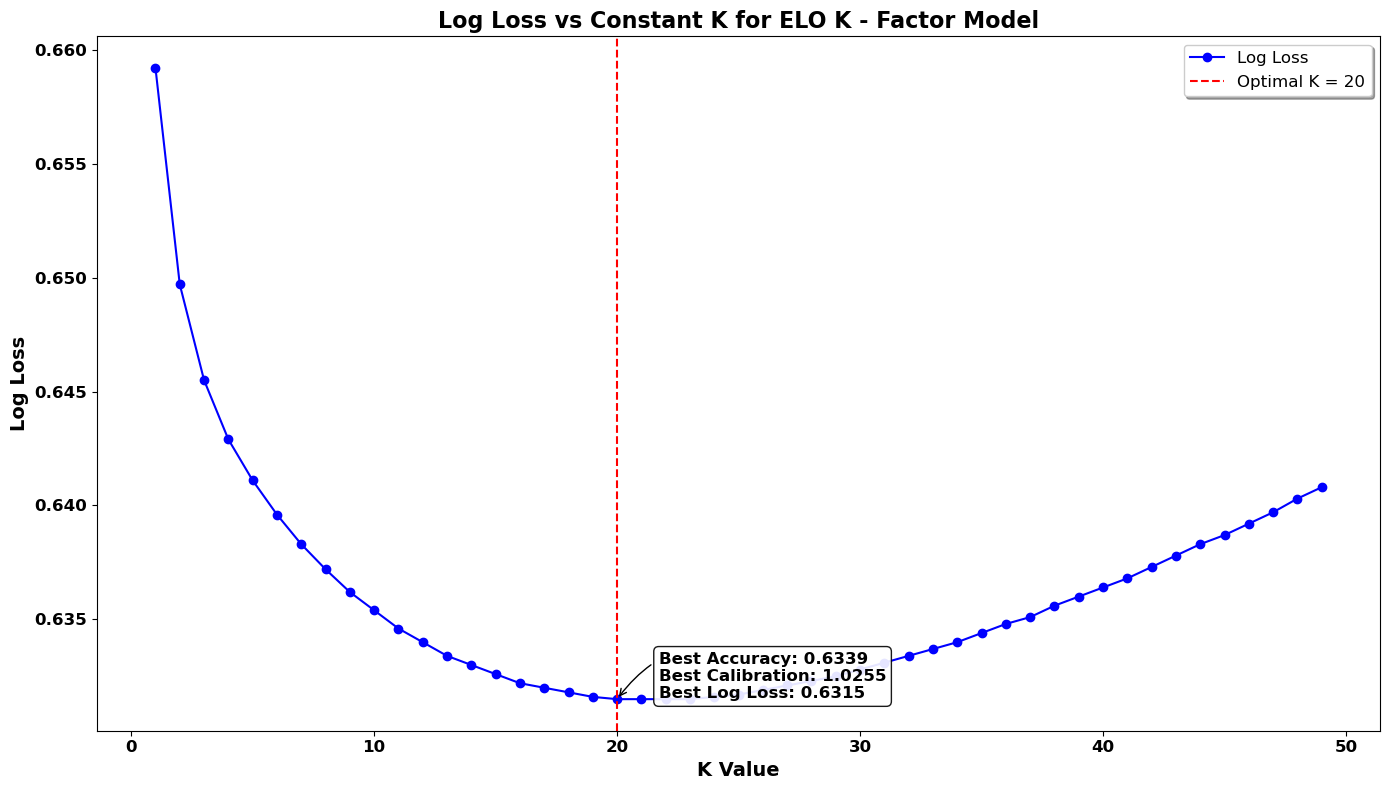

In [14]:
# Extract K values, accuracies, calibrations, and log losses from the results
k_values = [result[0] for result in results]
accuracies = [float(result[1]) for result in results]  # Assuming accuracies are also being analyzed
calibrations = [float(result[2]) for result in results]
log_losses = [float(result[3]) for result in results]

# Find the index of the minimum log loss
index_of_min_log_loss = log_losses.index(min(log_losses))

# Use the index to retrieve the optimal K and corresponding metrics
optimal_k_log_loss = k_values[index_of_min_log_loss]
best_accuracy = accuracies[index_of_min_log_loss]
best_calibration = calibrations[index_of_min_log_loss]
best_log_loss = log_losses[index_of_min_log_loss]

# Plot the results for log loss across different K values
plt.figure(figsize=(14, 8))
plt.plot(k_values, log_losses, label='Log Loss', color='blue', marker='o')  # Added markers for clarity
plt.axvline(optimal_k_log_loss, color='red', linestyle='--', label=f'Optimal K = {optimal_k_log_loss}')

# Set labels and titles with enhanced font settings
plt.xlabel('K Value', fontsize=14, fontweight='bold')
plt.ylabel('Log Loss', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.legend(fontsize=12, frameon=True, shadow=True)
plt.title('Log Loss vs Constant K for ELO K - Factor Model', fontsize=16, fontweight='bold')

# Annotate the graph with the best calibration and log loss values
# Bounding box and arrow style are adjusted for better visibility
annotation_text = f'Best Accuracy: {best_accuracy:.4f}\nBest Calibration: {best_calibration:.4f}\nBest Log Loss: {best_log_loss:.4f}'
plt.annotate(annotation_text,
             xy=(optimal_k_log_loss, best_log_loss),
             xytext=(optimal_k_log_loss + 10, best_log_loss - 0.05),  # Adjust text position for better legibility
             textcoords="offset points",  # Ensure that the positioning is relative
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.9),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5", color='black'),
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()